### Based on the observations, either we are not learning anything important from the training or we are not generalizing . all because of the different results in the validation

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import mysql.connector
from mysql.connector import Error
import pandas as pd
from mysql.connector import Error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Reshape, Layer, Lambda, Concatenate, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras import backend as be
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta
from keras.layers import BatchNormalization
from keras.regularizers import l2
import matplotlib.pyplot as plt
import LSTM_preprocessing as pre
import warnings
warnings.filterwarnings('ignore')

c:\Users\hgnik\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\hgnik\anaconda3\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

In [2]:
connection = pre.connect_to_database()
if connection:
    # Query merged data
    merged_df = pre.query_merged_crypto_data(connection)
    # converting US bond yield from hourly to yearly under continous compounding assumptions
    merged_df['yield'] = np.exp(merged_df['yield']*365*24)-1

    # Close the connection
    pre.query_quit(connection)

merged_df.head(3)

Connected to MySQL database, MySQL Server version:  8.0.39
MySQL connection is closed


,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,market_cap,coin_supply,yield
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,None,0.008552840317602313182744400
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,None,0.008552840317602313182744400
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,None,0.008552840317602313182744400


### merging with market cap

In [3]:
market_caps = pd.read_csv('market_cap_data.csv')
market_caps = market_caps.rename(columns={
    'timestamp': 'date',
    'token': 'crypto_symbol',
})
market_caps.head(3)

,Unnamed: 0,date,market_cap,crypto_symbol
0,0,2020-12-21 00:00:00,87121414,1INCHUSDT
1,1,2020-12-21 01:00:00,87121414,1INCHUSDT
2,2,2020-12-21 02:00:00,87121414,1INCHUSDT


In [4]:
# Convert 'date' columns to pandas datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])
market_caps['date'] = pd.to_datetime(market_caps['date'])

# Perform the merge based on 'crypto_symbol' and 'date', keeping only rows in merged_df
merged_df.drop('market_cap', axis = 1, inplace=True)
merged_df = pd.merge(
    merged_df,
    market_caps[['date', 'market_cap', 'crypto_symbol']],
    on=['date', 'crypto_symbol'],
    how='left'
)

merged_df.head(3)

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,coin_supply,yield,market_cap
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,0.008552840317602313182744400,317700843.0
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,0.008552840317602313182744400,317700843.0
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,0.008552840317602313182744400,317700843.0


In [5]:
merged_df.isna().sum()

lending_rate               0
borrowing_rate             0
utilization_rate           0
stable_borrow_rate         0
crypto_symbol              0
date                       0
high                       0
low                        0
close                      0
adj_close                  0
volume                     0
coin_supply           487675
yield                      0
market_cap              5638
dtype: int64

In [6]:
merged_df[merged_df['market_cap'].isna()].head(3)

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,coin_supply,yield,market_cap
66770,-50.000000,-50.000000,-50.000000,0.030000,KNCUSDT,2020-12-02 14:00:00,1.02,1.01,1.01,1.01,66643,None,0.008552840317602313182744400,NaN
66771,-50.000000,-50.000000,-50.000000,0.030000,KNCUSDT,2020-12-02 15:00:00,1.01,1.00,1.01,1.01,81810,None,0.008552840317602313182744400,NaN
66772,-50.000000,-50.000000,0.333333,0.030000,KNCUSDT,2020-12-02 16:00:00,1.01,1.00,1.00,1.00,61898,None,0.008552840317602313182744400,NaN


In [7]:
market_caps[market_caps['crypto_symbol'] == 'KNCUSDT'].head(3)

,Unnamed: 0,date,market_cap,crypto_symbol
226302,226302,2021-07-26 00:00:00,284924659,KNCUSDT
226303,226303,2021-07-26 01:00:00,284924659,KNCUSDT
226304,226304,2021-07-26 02:00:00,284924659,KNCUSDT


In [8]:
# KNC has wrong data before 2021
merged_df = merged_df[merged_df['market_cap'].notna()]
merged_df.reset_index(inplace = True, drop=True)

In [9]:
merged_df_emb = pre.create_llm_embeddings(merged_df, "crypto_symbol", n_components=15)
merged_df_emb = pre.create_cyclical_encodings(merged_df_emb, "date")

In [10]:
merged_df_emb.columns

Index(['lending_rate', 'borrowing_rate', 'utilization_rate',
       'stable_borrow_rate', 'crypto_symbol', 'date', 'high', 'low', 'close',
       'adj_close', 'volume', 'coin_supply', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine'],
      dtype='object')

In [11]:
# data without NA rows if we needed 
filtered_df = merged_df_emb[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df['attention'] = filtered_df['volume'] * filtered_df['close']
filtered_df.drop(columns=['stable_borrow_rate','adj_close','coin_supply'], inplace=True)
filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)
# removing wbtc because of its small amuont of data in 2024
filtered_df = filtered_df[filtered_df['crypto_symbol'] != 'WBTCUSDT']
filtered_df.reset_index(inplace=True, drop=True)
print(len(filtered_df))
filtered_df.columns

401976


Index(['lending_rate', 'borrowing_rate', 'utilization_rate', 'crypto_symbol',
       'date', 'high', 'low', 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention'],
      dtype='object')

In [12]:
# We scale  market cap, attention, yield together as they are comparable
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)
filtered_df['yield'] = scaler.fit_transform(filtered_df[['yield']])
filtered_df['market_cap'] = scaler.fit_transform(filtered_df[['market_cap']])
filtered_df['attention'] = scaler.fit_transform(filtered_df[['attention']])

In [13]:
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 
input_output_combination = [
     {'input':48, 'output':48},
     {'input':96, 'output':8}
]
outlier_threshold = 'remove'
epoch_num = 50
bacth_size = 200
balancer = 2

preprocessing...
length of train, valid, test: 
(70549, 48, 8)
(41323, 48, 8)
(56869, 48, 8)
affter balancing distribution:
(70549, 48, 8)
borrow_rate_Y_train: [20945 27433 22171]
borrow_rate_Y_valid: [23487 14377  3459]
borrow_rate_Y_test: [32957 12219 11693]
Training...



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 80)                28480     
                                                                 
 dense (Dense)               (None, 3)                 243       
                                                                 
Total params: 28723 (112.20 KB)
Trainable params: 28723 (112.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


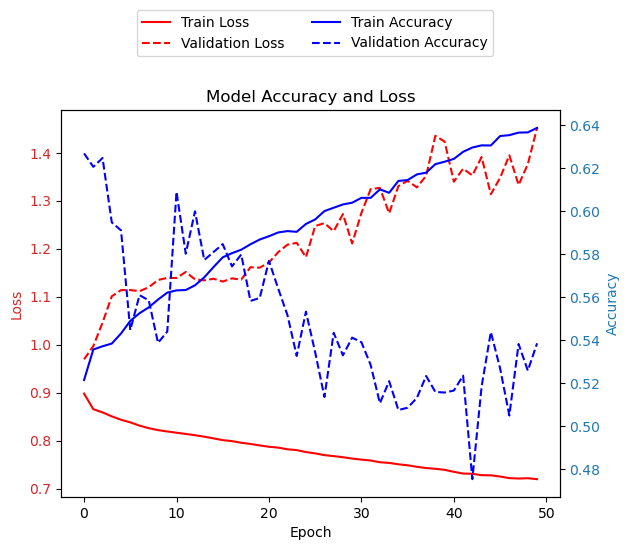

1778/1778 [==============================] - 8s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.4943114878053069, 'precision': 0.4062405681860513, 'recall': 0.41238361791927636, 'f1': 0.4060852394243711}
preprocessing...
length of train, valid, test: 
(65814, 96, 8)
(40212, 96, 8)
(55755, 96, 8)
affter balancing distribution:
(48155, 96, 8)
borrow_rate_Y_train: [23540 12845 11770]
borrow_rate_Y_valid: [35082  4278   852]
borrow_rate_Y_test: [49910  2985  2860]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 80)  

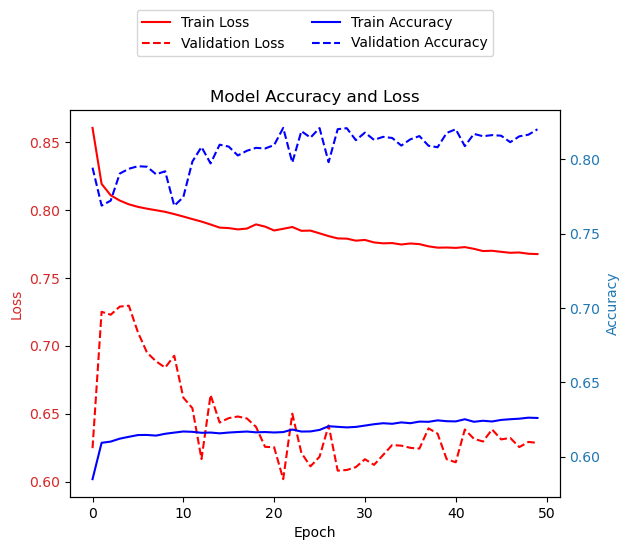

1743/1743 [==============================] - 14s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.8012913640032284, 'precision': 0.35856388080614554, 'recall': 0.3710867625979652, 'f1': 0.34942518307667375}


In [14]:
# a simple one layer LSTM
results_arr_2 = []
for comb in input_output_combination: 
    try:
        print('preprocessing...')
        input_window = comb['input'] #***
        output_window = comb['output'] #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        # Apply rebalancing
        X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

        print("affter balancing distribution:")
        print(X_train.shape)
        print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
        print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
        print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))

        print('Training...')
        Y_test, y_pred = pre.train_v6(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, batch_size=bacth_size)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'total_test_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr_2.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_2)

In [15]:
results.to_csv('one_layer_LSTM.csv')
results

,columns,total_test_windows,input_window,output_window,outlier_threshold,accuracy,precision,recall,f1
0,"['lending_rate', 'borrowing_rate', 'utilizatio...",56869,48,48,remove,0.494311,0.406241,0.412384,0.406085
1,"['lending_rate', 'borrowing_rate', 'utilizatio...",55755,96,8,remove,0.801291,0.358564,0.371087,0.349425


### The results for 48 input and 48 output shows overfitting that is why we will test regularization and early stopping
### The results for 98 input and 8 output is good but it need to be run for more epochs to converge

preprocessing...
length of train, valid, test: 
(70549, 48, 8)
(41323, 48, 8)
(56869, 48, 8)
affter balancing distribution:
(70549, 48, 8)
borrow_rate_Y_train: [20945 27433 22171]
borrow_rate_Y_valid: [23487 14377  3459]
borrow_rate_Y_test: [32957 12219 11693]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 80)                28480     
                                                                 
 dense (Dense)               (None, 3)                 243       
                                                                 
Total params: 28723 (112.20 KB)
Trainable params: 28723 (112.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


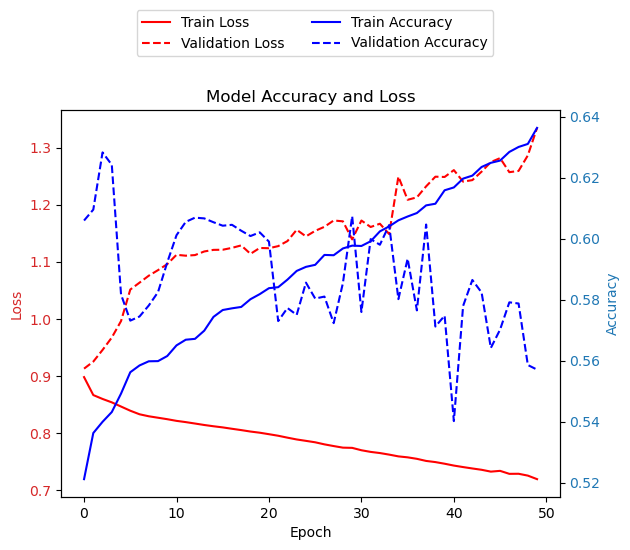

1778/1778 [==============================] - 8s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.46301148253002516, 'precision': 0.3632563270602088, 'recall': 0.3636334984958957, 'f1': 0.363406014836493}
preprocessing...
length of train, valid, test: 
(65814, 96, 8)
(40212, 96, 8)
(55755, 96, 8)
affter balancing distribution:
(48155, 96, 8)
borrow_rate_Y_train: [23540 12845 11770]
borrow_rate_Y_valid: [35082  4278   852]
borrow_rate_Y_test: [49910  2985  2860]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 80)   

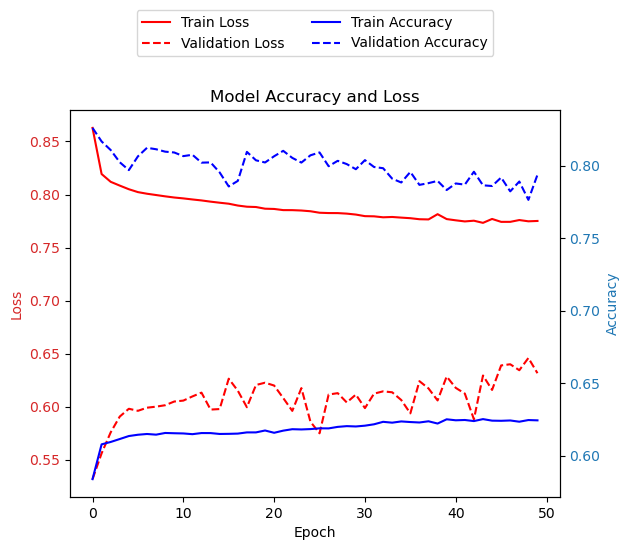

1743/1743 [==============================] - 14s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.7946551878755269, 'precision': 0.35631890617864964, 'recall': 0.3586341471584658, 'f1': 0.34360314136959463}


In [16]:
# simple LSTM with L2 - regularization and early stopping
results_arr_3 = []
for comb in input_output_combination: 
    try:
        print('preprocessing...')
        input_window = comb['input'] #***
        output_window = comb['output'] #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        # Apply rebalancing
        X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

        print("affter balancing distribution:")
        print(X_train.shape)
        print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
        print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
        print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))

        print('Training...')
        Y_test, y_pred = pre.train_v6(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, batch_size=bacth_size)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'total_test_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr_3.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_3)

In [17]:
results.to_csv('one_layer_LSTM_regularized.csv')
results

,columns,total_test_windows,input_window,output_window,outlier_threshold,accuracy,precision,recall,f1
0,"['lending_rate', 'borrowing_rate', 'utilizatio...",56869,48,48,remove,0.463011,0.363256,0.363633,0.363406
1,"['lending_rate', 'borrowing_rate', 'utilizatio...",55755,96,8,remove,0.794655,0.356319,0.358634,0.343603


### The results are not getting better with L2 Regularization and Early stopping , therefore we dont use this model.

In [18]:
# we will try different optimizers and also differentdropout rates for better generalization

input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 
input_output_combination = [
     {'input':48, 'output':48},
     {'input':96, 'output':8}
]
outlier_threshold = 'remove'
epoch_num = 50
bacth_size = 200
balancer = 2
dropout_list = [0.1, 0.4]
cell_sizes = [40, 80, 120]
optimizers = ['adamw', 'adadelta', 'rmsprop']

preprocessing...
Training...


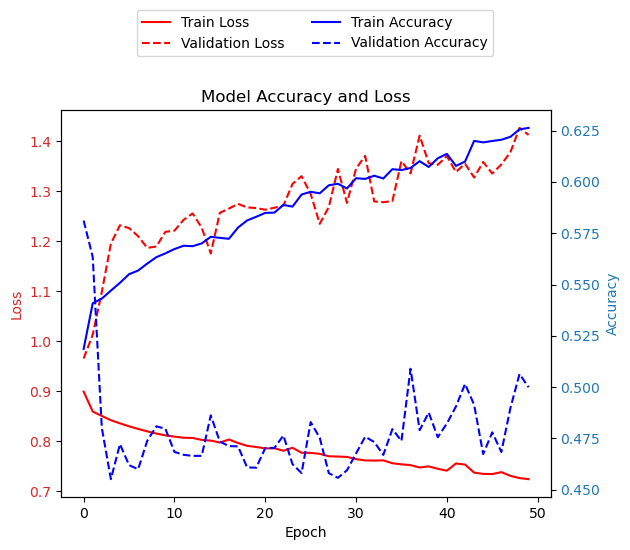

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.4033656297807241, 'precision': 0.37459843339195076, 'recall': 0.3765797420912686, 'f1': 0.36183289393930423}
preprocessing...
Training...


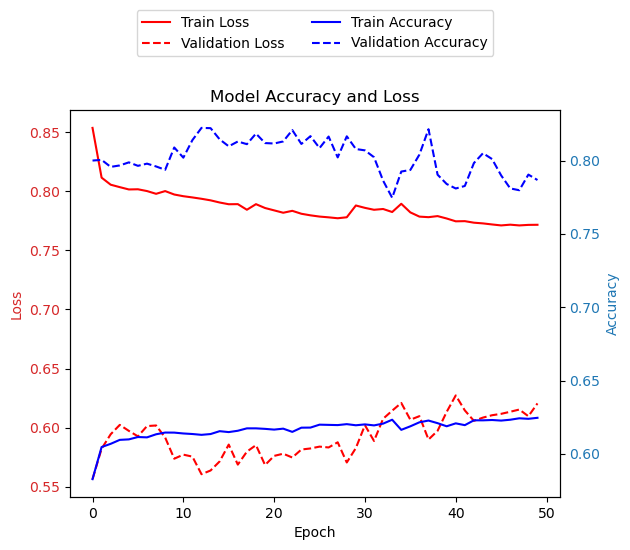

1743/1743 [==============================] - 10s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.7821899381221415, 'precision': 0.3511208323088046, 'recall': 0.3601208554770192, 'f1': 0.34726582469602724}
preprocessing...
Training...


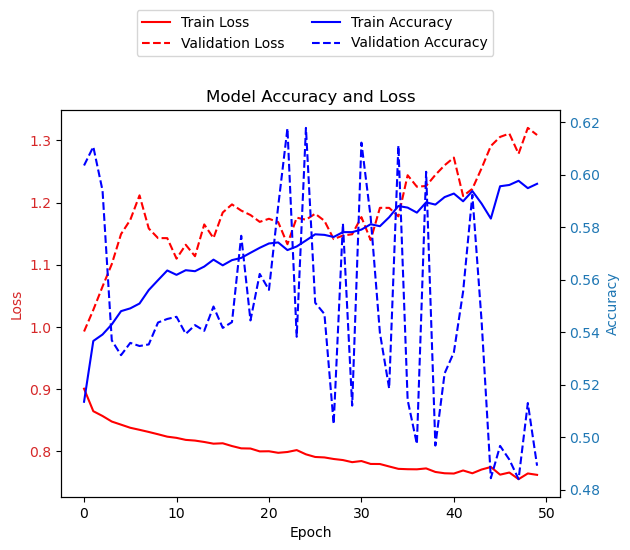

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.4536214809474406, 'precision': 0.3661242820312369, 'recall': 0.3661505401484077, 'f1': 0.36605182012118337}
preprocessing...
Training...


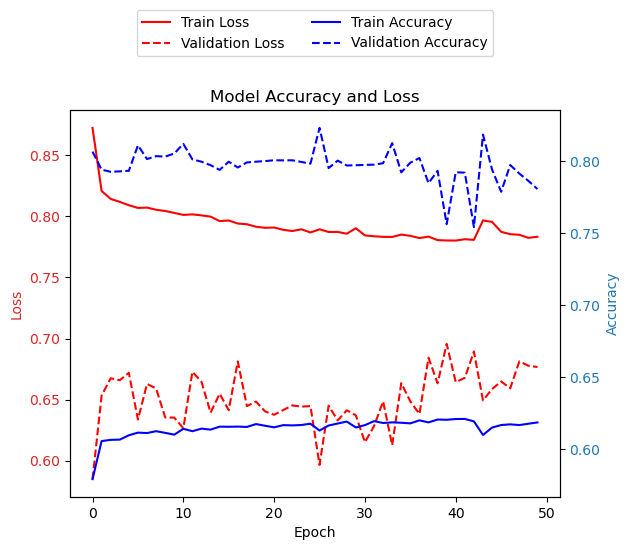

1743/1743 [==============================] - 9s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.7833916240695902, 'precision': 0.34892614308102776, 'recall': 0.35550436733808005, 'f1': 0.3444611548572769}
preprocessing...
Training...


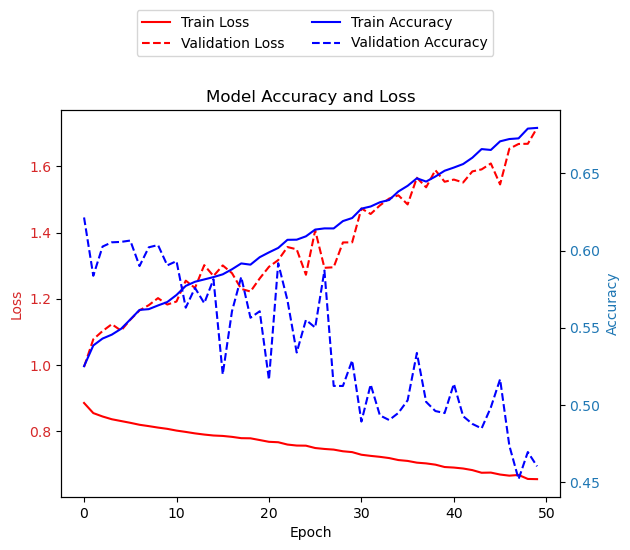

1778/1778 [==============================] - 8s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.43971232129982946, 'precision': 0.3781642476663793, 'recall': 0.3817090194252164, 'f1': 0.3749336205015037}
preprocessing...
Training...


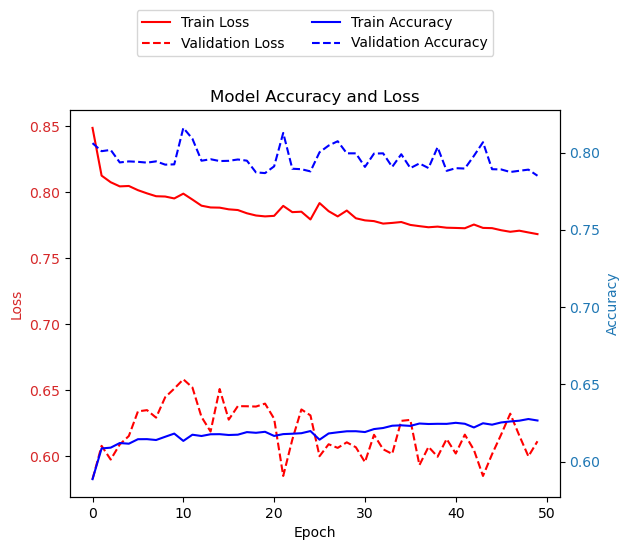

1743/1743 [==============================] - 14s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.7963590709353421, 'precision': 0.342215061070368, 'recall': 0.34831541785032943, 'f1': 0.3373885039474617}
preprocessing...
Training...


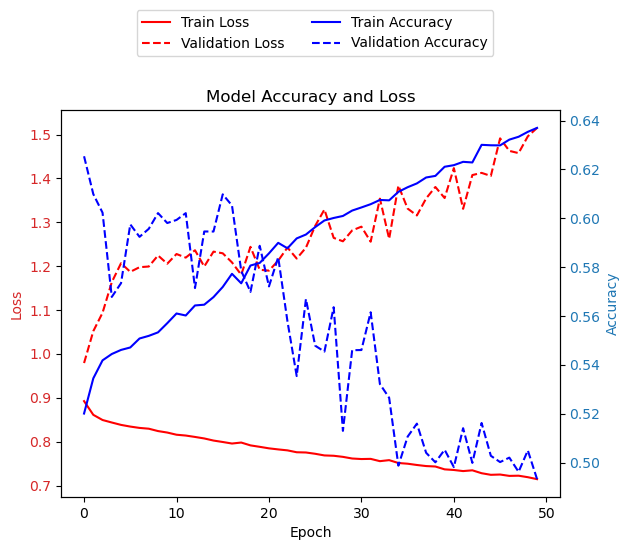

1778/1778 [==============================] - 9s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.3703775343332923, 'precision': 0.3393964084389967, 'recall': 0.3366499940218403, 'f1': 0.3283445941438836}
preprocessing...
Training...


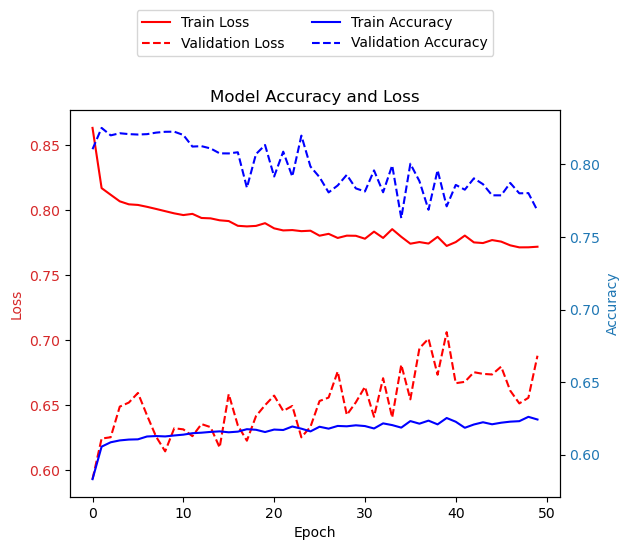

1743/1743 [==============================] - 15s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.7417810061877859, 'precision': 0.34797178915503313, 'recall': 0.35715474717321255, 'f1': 0.34324397549905833}
preprocessing...
Training...


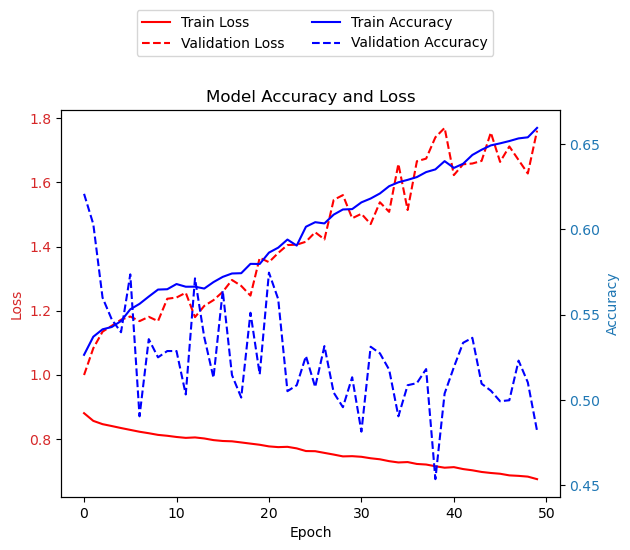

1778/1778 [==============================] - 10s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.33190314582637287, 'precision': 0.37524232559742954, 'recall': 0.3549747111781143, 'f1': 0.3131666556452685}
preprocessing...
Training...


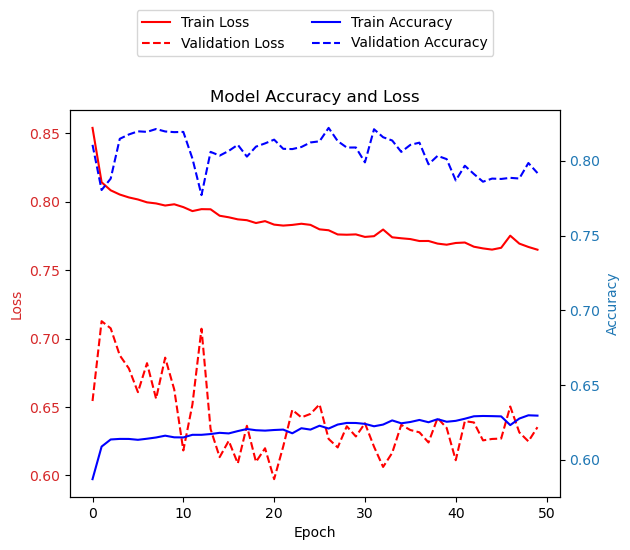

1743/1743 [==============================] - 20s 11ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.7886646937494395, 'precision': 0.34168530242909007, 'recall': 0.35650607232535103, 'f1': 0.3388205272881381}
preprocessing...
Training...


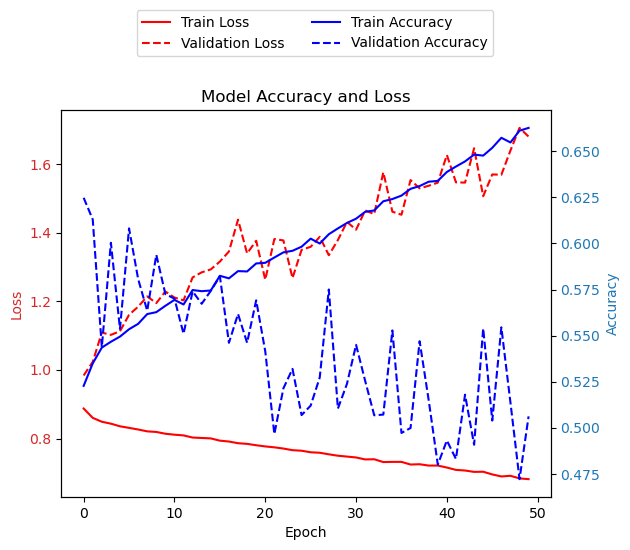

1778/1778 [==============================] - 10s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.39330742583833017, 'precision': 0.3632364677370812, 'recall': 0.36756312978698075, 'f1': 0.35229010911741704}
preprocessing...
Training...


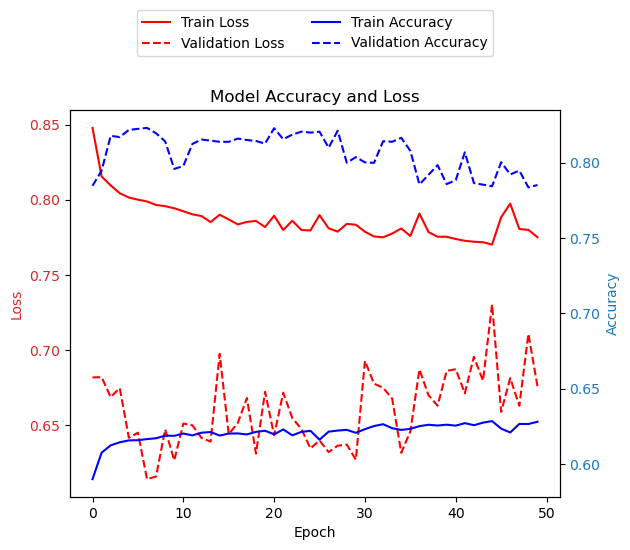

1743/1743 [==============================] - 20s 11ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.7843960182943234, 'precision': 0.3461726723626324, 'recall': 0.35667448736052626, 'f1': 0.3399292113659647}
preprocessing...
Training...


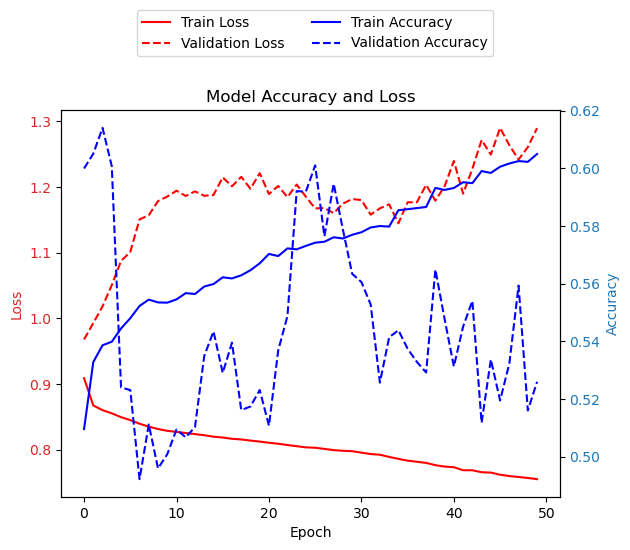

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.4526367616803531, 'precision': 0.37071410076963024, 'recall': 0.38337465370264917, 'f1': 0.3549718940735865}
preprocessing...
Training...


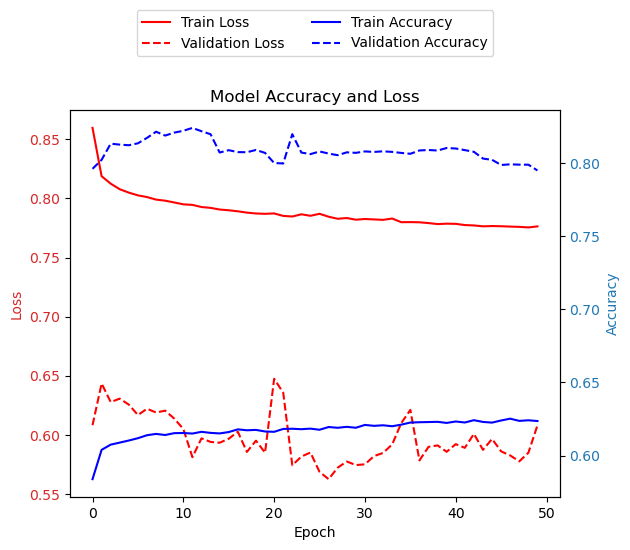

1743/1743 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.798206438884405, 'precision': 0.34590900044895717, 'recall': 0.35563976084354976, 'f1': 0.3396073670031103}
preprocessing...
Training...


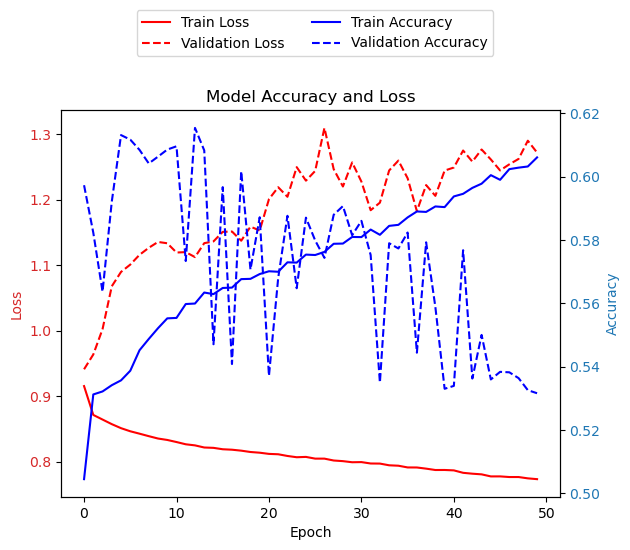

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.40837714747929454, 'precision': 0.41026081041690493, 'recall': 0.40910385220960427, 'f1': 0.36022759188943326}
preprocessing...
Training...


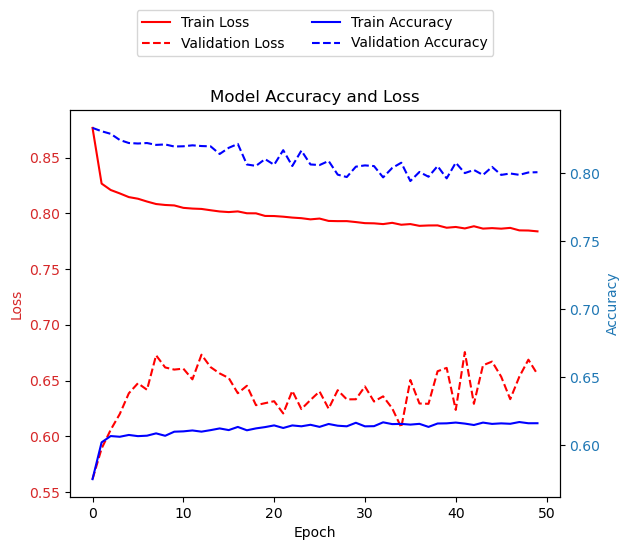

1743/1743 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.7774908079992826, 'precision': 0.36891602940980955, 'recall': 0.37178068700442135, 'f1': 0.3467030080650584}
preprocessing...
Training...


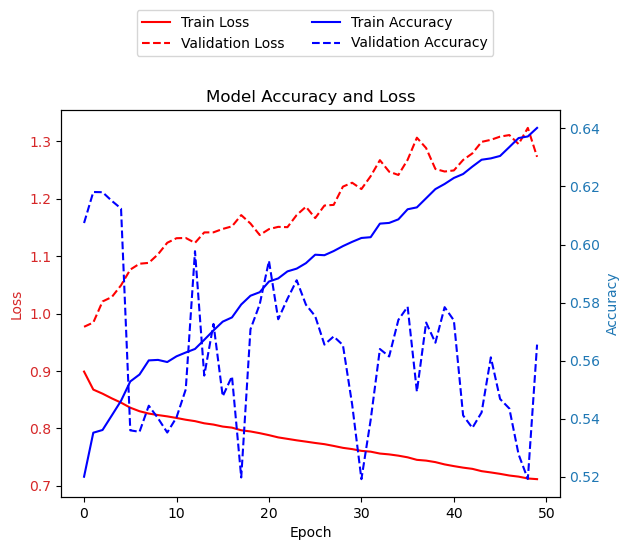

1778/1778 [==============================] - 9s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.41393377762928835, 'precision': 0.41431410177239303, 'recall': 0.40858557975926146, 'f1': 0.35496277411110655}
preprocessing...
Training...


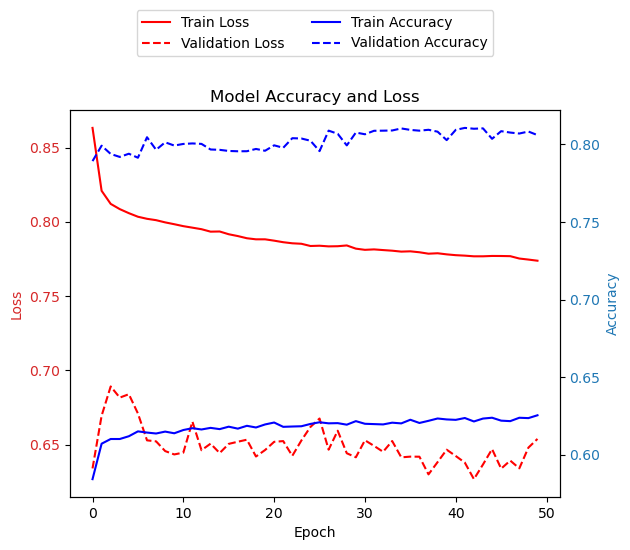

1743/1743 [==============================] - 15s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.8098645861357726, 'precision': 0.35313687138706035, 'recall': 0.3649154744367837, 'f1': 0.3477107390869662}
preprocessing...
Training...


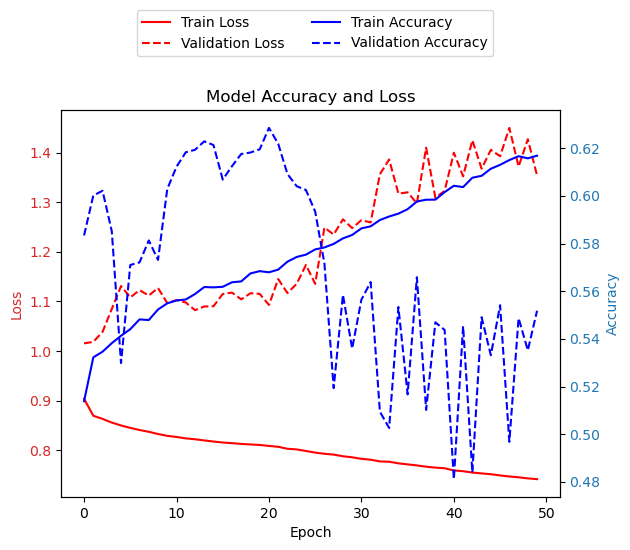

1778/1778 [==============================] - 8s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.41825950869542283, 'precision': 0.3785981506676499, 'recall': 0.37911806220313665, 'f1': 0.36165105244593215}
preprocessing...
Training...


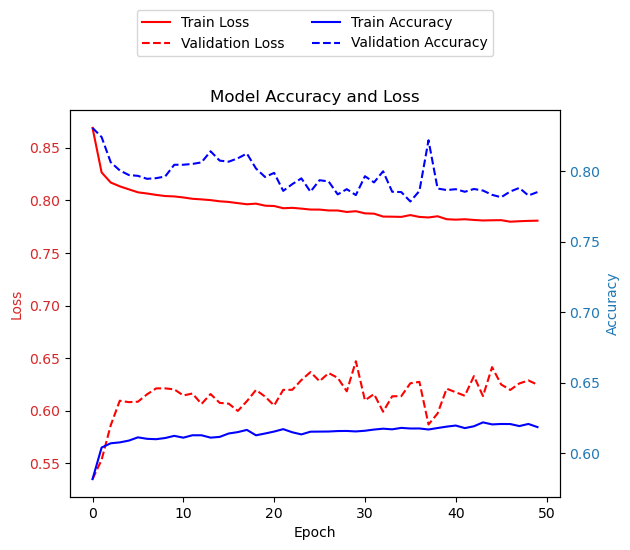

1743/1743 [==============================] - 15s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.7979015334947538, 'precision': 0.36324622038399884, 'recall': 0.3580091135889059, 'f1': 0.3515319249900344}
preprocessing...
Training...


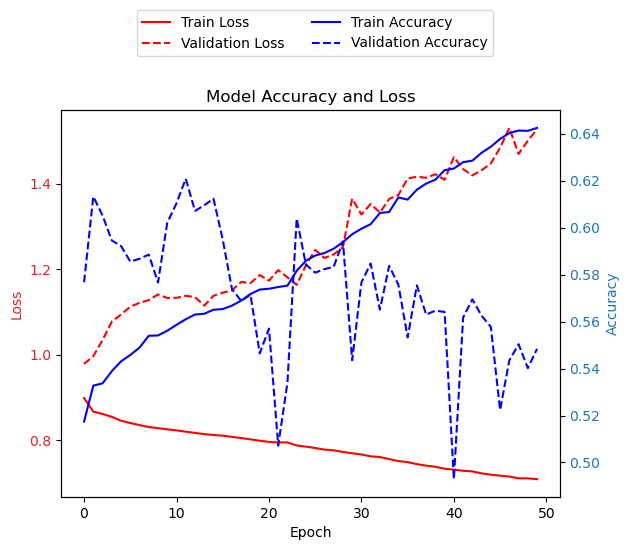

1778/1778 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.459195695370061, 'precision': 0.41499152195208105, 'recall': 0.4196521376905094, 'f1': 0.39928645365761}
preprocessing...
Training...


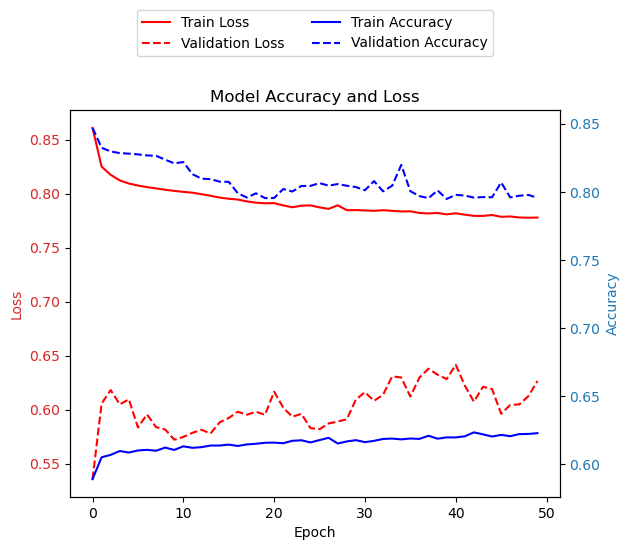

1743/1743 [==============================] - 22s 12ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.8058111380145279, 'precision': 0.35142262249968725, 'recall': 0.363088621620411, 'f1': 0.34875441721201456}
preprocessing...
Training...


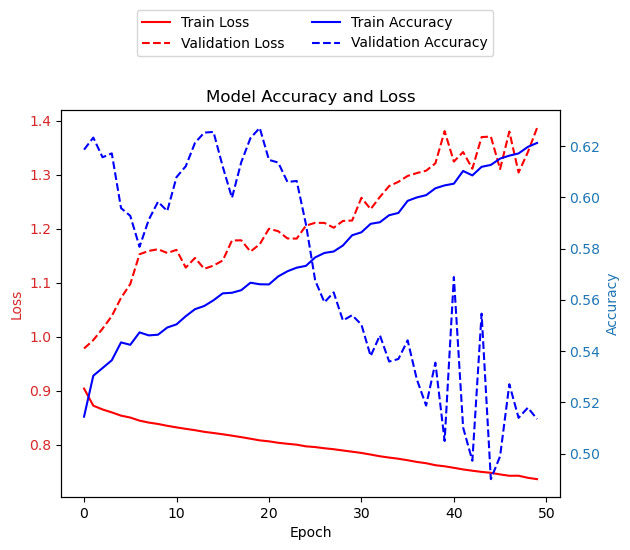

1778/1778 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.37814978283423306, 'precision': 0.416642094340067, 'recall': 0.38008907162841893, 'f1': 0.3404088193692354}
preprocessing...
Training...


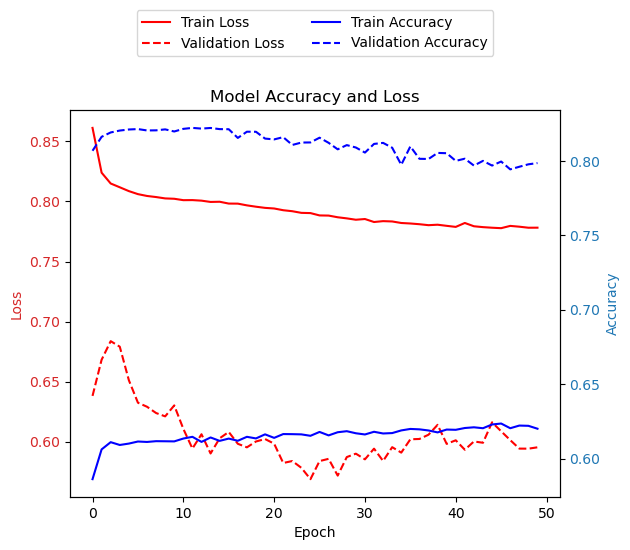

1743/1743 [==============================] - 21s 12ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.805380683346785, 'precision': 0.3469236518283329, 'recall': 0.35275648666692244, 'f1': 0.3395091330800146}
preprocessing...
Training...


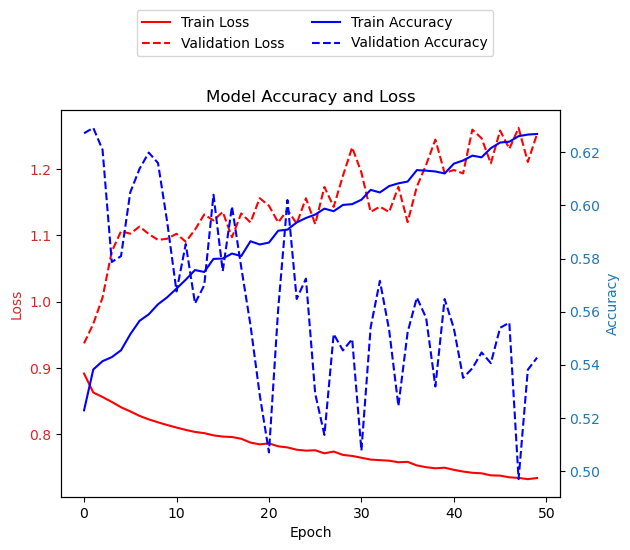

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.5007121630413758, 'precision': 0.40360228799125847, 'recall': 0.4048795395691167, 'f1': 0.40395311856698707}
preprocessing...
Training...


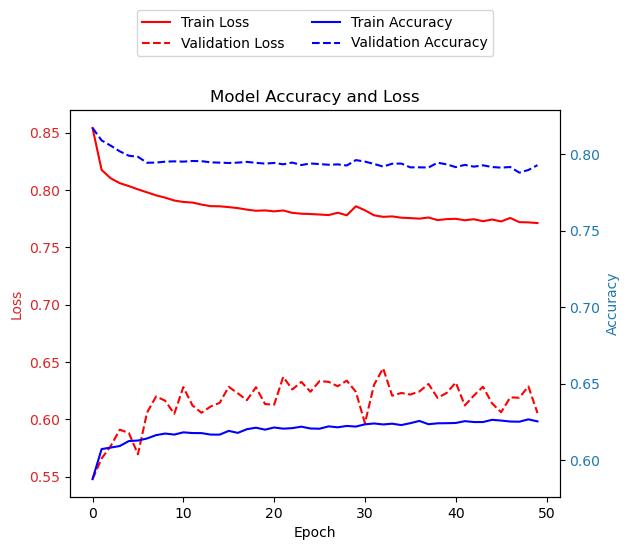

1743/1743 [==============================] - 10s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.8071563088512241, 'precision': 0.3667291423206604, 'recall': 0.36924426961428236, 'f1': 0.35692524835952577}
preprocessing...
Training...


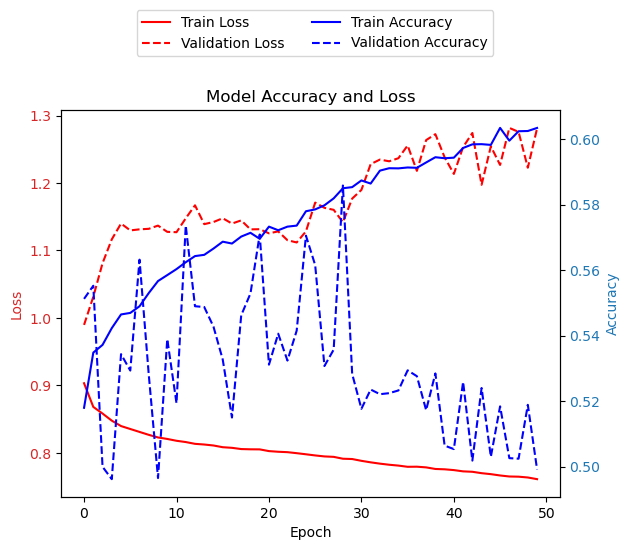

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.42981237581107457, 'precision': 0.4027901442790924, 'recall': 0.4084301440670879, 'f1': 0.38752571618362514}
preprocessing...
Training...


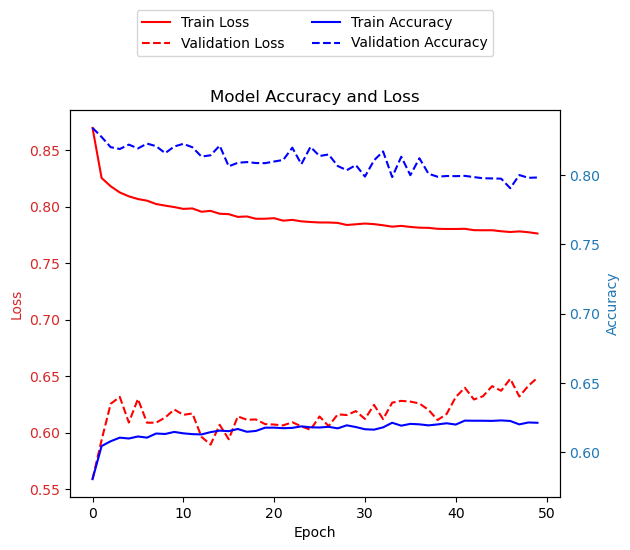

1743/1743 [==============================] - 10s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.7903506411980988, 'precision': 0.36282559331354247, 'recall': 0.37361492298237736, 'f1': 0.35051557123932514}
preprocessing...
Training...


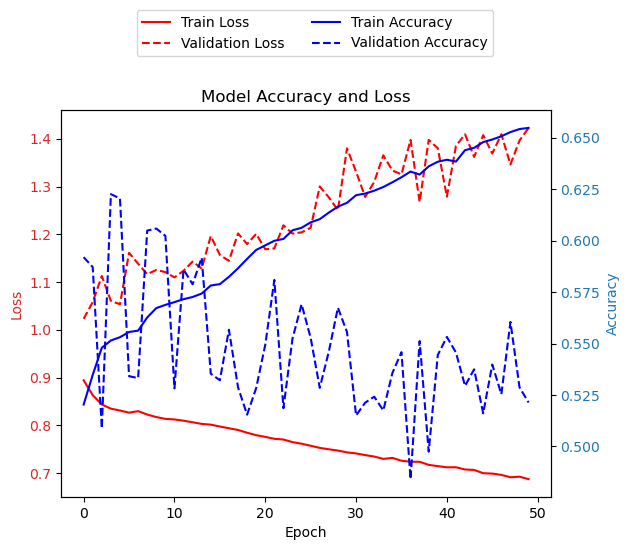

1778/1778 [==============================] - 10s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.4135820921767571, 'precision': 0.3913135695637094, 'recall': 0.3913366245888749, 'f1': 0.3774392275291229}
preprocessing...
Training...


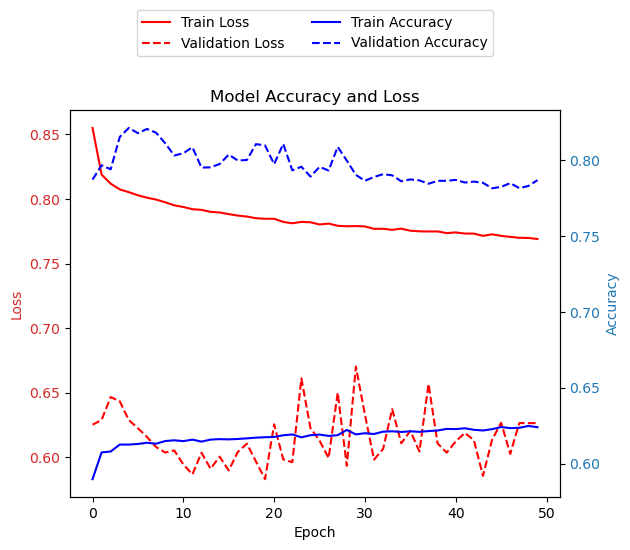

1743/1743 [==============================] - 17s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.7802708277284548, 'precision': 0.34219561389985437, 'recall': 0.35304833496457816, 'f1': 0.3375733270154879}
preprocessing...
Training...


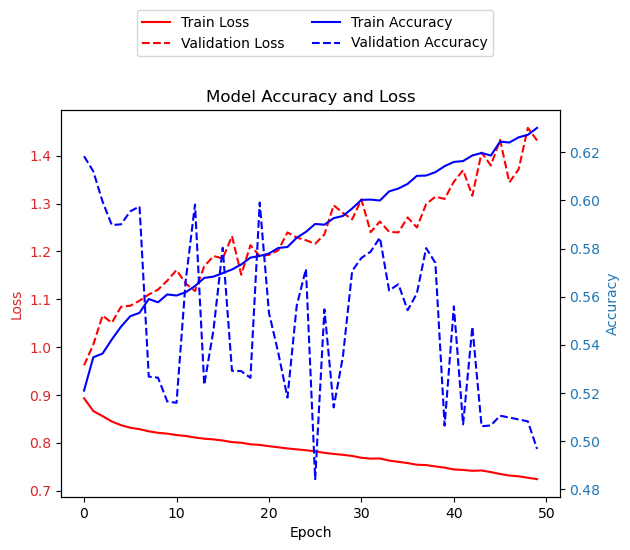

1778/1778 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.41484815980586964, 'precision': 0.36027416569766896, 'recall': 0.36211132051939776, 'f1': 0.35765118545065105}
preprocessing...
Training...


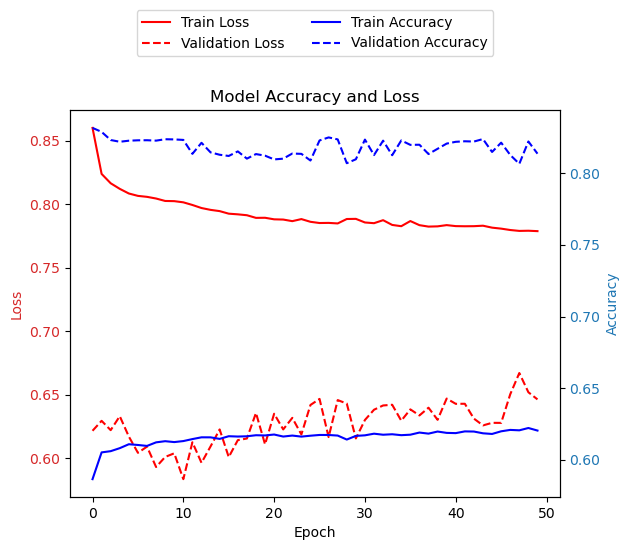

1743/1743 [==============================] - 18s 10ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.7947089947089947, 'precision': 0.3556980652484034, 'recall': 0.36796669410404287, 'f1': 0.34479118181331936}
preprocessing...
Training...


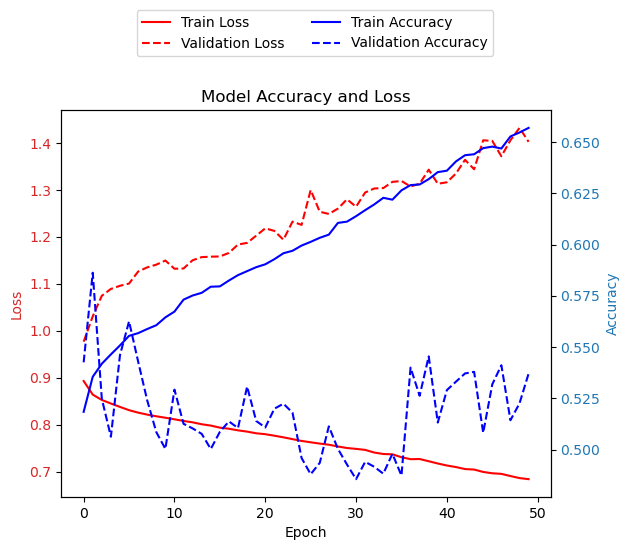

1778/1778 [==============================] - 12s 7ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.47931210325484885, 'precision': 0.39005144598971125, 'recall': 0.3773369871213034, 'f1': 0.3781521163690806}
preprocessing...
Training...


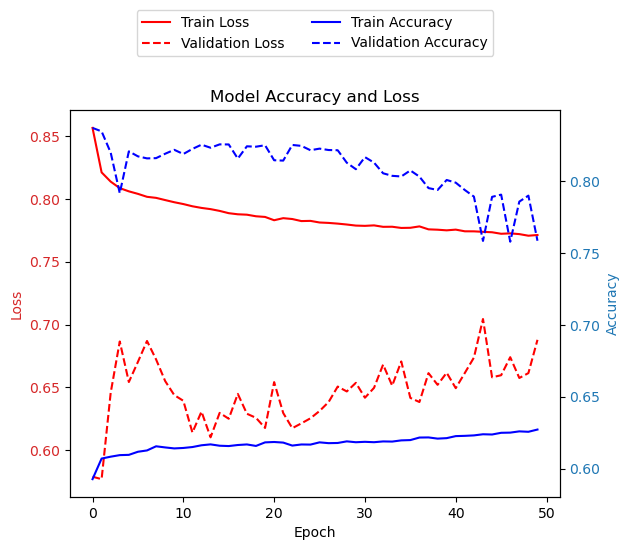

1743/1743 [==============================] - 23s 13ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.7689713927002063, 'precision': 0.33584832339221765, 'recall': 0.34525404946514704, 'f1': 0.3278158093540053}
preprocessing...
Training...


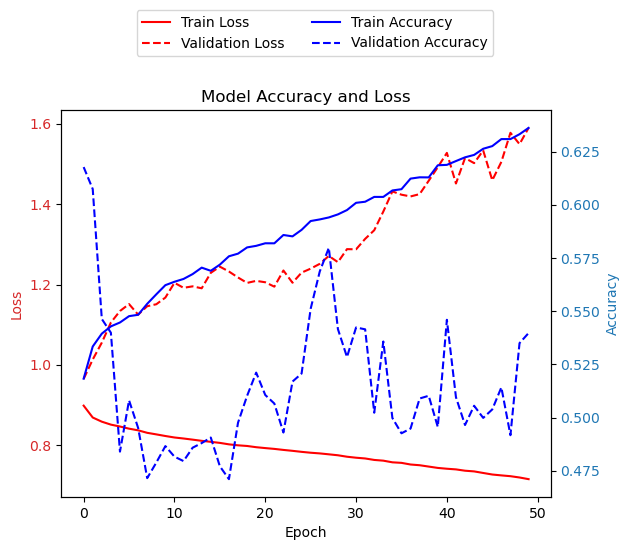

1778/1778 [==============================] - 13s 7ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.39939158416712095, 'precision': 0.3551288776878867, 'recall': 0.36465996132597195, 'f1': 0.3380011911001255}
preprocessing...
Training...


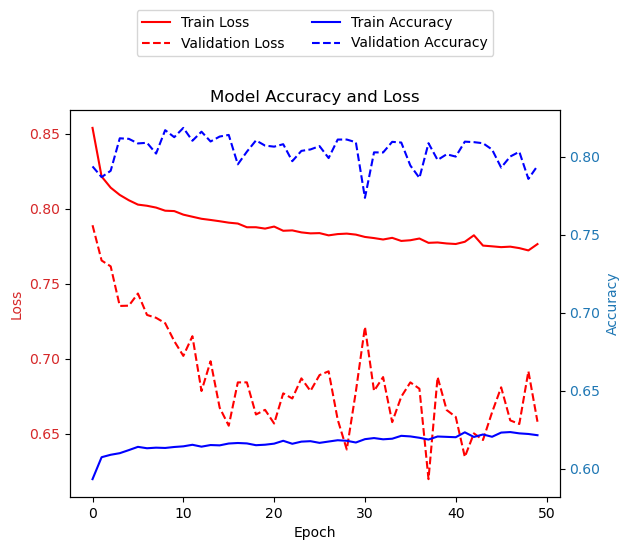

1743/1743 [==============================] - 24s 13ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.7820823244552058, 'precision': 0.3577437247509976, 'recall': 0.36429040194712886, 'f1': 0.33876070679473874}


In [22]:
# grid search with train_v9 for optimizers and dropout rates
results_arr_10 = []
for optimizer in optimizers:
    for cell_size in cell_sizes:
        for dropout in dropout_list:
            for comb in input_output_combination: 
                try:
                    print('preprocessing...')
                    input_window = comb['input'] #***
                    output_window = comb['output'] #***

                    # Initialize empty lists to store aggregated inputs and targets
                    X_train,X_valid,X_test = [], [], []
                    Y_train,Y_valid,Y_test = [], [], []
                    # looping through symbols
                    symbols = filtered_df['crypto_symbol'].unique()
                    for s in symbols:
                        try:
                            sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                            sim_df.reset_index(inplace=True, drop=True)
                            
                            # First Loop: Calculate intervals for each column without modifying the DataFrame
                            intervals = {}
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                                intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                                # getting the returns
                            reduced_df = sim_df.copy()
                            reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                            reduced_df = reduced_df[reduced_df['returns'].notna()]
                            reduced_df.reset_index(inplace=True, drop=True)

                            # Second Loop: Filter rows based on the pre-calculated intervals
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower_bound = intervals[column]['lower_bound']
                                upper_bound = intervals[column]['upper_bound']
                                # Apply filtering based on pre-calculated bounds
                                reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                            reduced_df.reset_index(inplace=True, drop=True)

                            # MinMax scaling
                            scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                            scaled_df = reduced_df.copy()
                            scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                            scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                            scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                            scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                            scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                            scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                            inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                            'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                            # Append results from the current DataFrame
                            X_train.append(inputs_train)
                            X_valid.append(inputs_valid)
                            X_test.append(inputs_test)
                            Y_train.append(targets_train)
                            Y_valid.append(targets_valid)
                            Y_test.append(targets_test)

                        # Handle any other exceptions
                        except Exception as e:
                            print(f"Unexpected error in symbol {s}: {e}")

                    # Concatenate all inputs and targets into single arrays
                    X_train = [arr for arr in X_train if len(arr) > 0]
                    X_valid = [arr for arr in X_valid if len(arr) > 0]
                    X_test = [arr for arr in X_test if len(arr) > 0]

                    Y_train = [arr for arr in Y_train if len(arr) > 0]
                    Y_valid = [arr for arr in Y_valid if len(arr) > 0]
                    Y_test = [arr for arr in Y_test if len(arr) > 0]

                    X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
                    X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
                    X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

                    Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
                    Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
                    Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
                    # Lending rate
                    lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
                    lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
                    lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
                    # Borrowing rate
                    borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
                    borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
                    borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

                    # print('length of train, valid, test: ')
                    # print(X_train.shape)
                    # print(X_valid.shape)
                    # print(X_test.shape)

                    # Apply rebalancing
                    X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

                    # print("after balancing distribution:")
                    # print(X_train.shape)
                    # print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
                    # print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
                    # print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))

                    print('Training...')
                    Y_test, y_pred = pre.train_v9(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, 
                                                  batch_size=bacth_size, cell_size=cell_size, dropout_rate=dropout, optimizer_name=optimizer)
                    
                    accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

                    total_windows = Y_test.shape[0]
                        
                    new_row = {
                        'columns': f'{input_columns}',
                        'total_test_windows':total_windows,
                        'input_window':input_window,
                        'output_window':output_window, 
                        'outlier_threshold':outlier_threshold,
                        'optimizer':optimizer,
                        'cell_size':cell_size,
                        'dropout':dropout, 
                        'accuracy':accuracy, 
                        'precision':precision, 
                        'recall':recall, 
                        'f1':f1
                    }
                    results_arr_10.append(new_row)
                    print(new_row)
                    
                except Exception as e:
                    print(f"Error occurred with {input_columns}")
                    print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_10)

In [23]:
results.to_csv('optimizers_dropouts.csv')
results

,columns,total_test_windows,input_window,output_window,outlier_threshold,optimizer,cell_size,dropout,accuracy,precision,recall,f1
0,"['lending_rate', 'borrowing_rate', 'utilizatio...",56869,48,48,remove,adamw,40,0.1,0.403366,0.374598,0.376580,0.361833
1,"['lending_rate', 'borrowing_rate', 'utilizatio...",55755,96,8,remove,adamw,40,0.1,0.782190,0.351121,0.360121,0.347266
2,"['lending_rate', 'borrowing_rate', 'utilizatio...",56869,48,48,remove,adamw,40,0.4,0.453621,0.366124,0.366151,0.366052
3,"['lending_rate', 'borrowing_rate', 'utilizatio...",55755,96,8,remove,adamw,40,0.4,0.783392,0.348926,0.355504,0.344461
4,"['lending_rate', 'borrowing_rate', 'utilizatio...",56869,48,48,remove,adamw,80,0.1,0.439712,0.378164,0.381709,0.374934
5,"['lending_rate', 'borrowing_rate', 'utilizatio...",55755,96,8,remove,adamw,80,0.1,0.796359,0.342215,0.348315,0.337389
6,"['lending_rate', 'borrowing_rate', 'utilizatio...",56869,48,48,remove,adamw,80,0.4,0.370378,0.339396,0.336650,0.328345
7,"['lending_rate', 'borrowing_rate', 'utilizatio...",55755,96,8,remove,adamw,80,0.4,0.741781,0.347972,0.357155,0.343244
8,"['lending_rate', 'borrowing_rate', 'utilizatio...",56869,48,48,remove,adamw,120,0.1,0.331903,0.375242,0.354975,0.313167
9,"['lending_rate', 'borrowing_rate', 'utilizatio...",55755,96,8,remove,adamw,120,0.1,0.788665,0.341685,0.356506,0.338821


### Best result is for rmsprop , with 40 cell-size , and 0.1 dropout rate, this brings up the question that does it help to reduce the cell size and dropout more.

In [24]:
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 
input_output_combination = [
     {'input':48, 'output':48},
]
outlier_threshold = 'remove'
epoch_num = 50
bacth_size = 200
balancer = 2
dropout_list = [0.02, 0.05, 0.1]
cell_sizes = [10, 20, 40]
optimizers = ['rmsprop']

In [ ]:
# grid search with train_v9 for optimizers and dropout rates
results_arr_11 = []
for optimizer in optimizers:
    for cell_size in cell_sizes:
        for dropout in dropout_list:
            for comb in input_output_combination: 
                try:
                    print('preprocessing...')
                    input_window = comb['input'] #***
                    output_window = comb['output'] #***

                    # Initialize empty lists to store aggregated inputs and targets
                    X_train,X_valid,X_test = [], [], []
                    Y_train,Y_valid,Y_test = [], [], []
                    # looping through symbols
                    symbols = filtered_df['crypto_symbol'].unique()
                    for s in symbols:
                        try:
                            sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                            sim_df.reset_index(inplace=True, drop=True)
                            
                            # First Loop: Calculate intervals for each column without modifying the DataFrame
                            intervals = {}
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                                intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                                # getting the returns
                            reduced_df = sim_df.copy()
                            reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                            reduced_df = reduced_df[reduced_df['returns'].notna()]
                            reduced_df.reset_index(inplace=True, drop=True)

                            # Second Loop: Filter rows based on the pre-calculated intervals
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower_bound = intervals[column]['lower_bound']
                                upper_bound = intervals[column]['upper_bound']
                                # Apply filtering based on pre-calculated bounds
                                reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                            reduced_df.reset_index(inplace=True, drop=True)

                            # MinMax scaling
                            scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                            scaled_df = reduced_df.copy()
                            scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                            scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                            scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                            scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                            scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                            scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                            inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                            'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                            # Append results from the current DataFrame
                            X_train.append(inputs_train)
                            X_valid.append(inputs_valid)
                            X_test.append(inputs_test)
                            Y_train.append(targets_train)
                            Y_valid.append(targets_valid)
                            Y_test.append(targets_test)

                        # Handle any other exceptions
                        except Exception as e:
                            print(f"Unexpected error in symbol {s}: {e}")

                    # Concatenate all inputs and targets into single arrays
                    X_train = [arr for arr in X_train if len(arr) > 0]
                    X_valid = [arr for arr in X_valid if len(arr) > 0]
                    X_test = [arr for arr in X_test if len(arr) > 0]

                    Y_train = [arr for arr in Y_train if len(arr) > 0]
                    Y_valid = [arr for arr in Y_valid if len(arr) > 0]
                    Y_test = [arr for arr in Y_test if len(arr) > 0]

                    X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
                    X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
                    X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

                    Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
                    Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
                    Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
                    # Lending rate
                    lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
                    lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
                    lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
                    # Borrowing rate
                    borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
                    borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
                    borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

                    # print('length of train, valid, test: ')
                    # print(X_train.shape)
                    # print(X_valid.shape)
                    # print(X_test.shape)

                    # Apply rebalancing
                    X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

                    # print("after balancing distribution:")
                    # print(X_train.shape)
                    # print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
                    # print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
                    # print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))

                    print('Training...')
                    Y_test, y_pred = pre.train_v9(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, 
                                                  batch_size=bacth_size, cell_size=cell_size, dropout_rate=dropout, optimizer_name=optimizer)
                    
                    accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

                    total_windows = Y_test.shape[0]
                        
                    new_row = {
                        'columns': f'{input_columns}',
                        'total_test_windows':total_windows,
                        'input_window':input_window,
                        'output_window':output_window, 
                        'outlier_threshold':outlier_threshold,
                        'optimizer':optimizer,
                        'cell_size':cell_size,
                        'dropout':dropout, 
                        'accuracy':accuracy, 
                        'precision':precision, 
                        'recall':recall, 
                        'f1':f1
                    }
                    results_arr_11.append(new_row)
                    print(new_row)
                    
                except Exception as e:
                    print(f"Error occurred with {input_columns}")
                    print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_11)

preprocessing...


In [ ]:
results.to_csv('rms_prop_metrics.csv')
results